In [17]:
!python -V
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt


rng = np.random.default_rng(1234)

Python 3.13.3


# Question 1

## (a)

For the model

$$ dX_t = rX_t dt + \sigma X_{t}^\gamma dW_t $$

We note that the associated PDE for the corridor option price $V(t, x)$ is

$$
\begin{align*}
    &\frac{\partial V}{\partial t} + rx \frac{\partial V}{\partial x} + \frac{\sigma^2 x^{2\gamma}}{2} \frac{\partial^2 V}{\partial x^2} - rV = 0 \\
    &\\
    &V(T, x) = 𝟙_{[15, 25]} (x)
\end{align*}
$$

We recall that $V^{m}_{n} = V(m\Delta t, x_\mathrm{min} + n \Delta x)$ and the discretizations for the implicit scheme is given by

$$
\begin{align*}
    \frac{\partial V}{\partial t} &\approx \frac{V^{m}_{n} - V^{m-1}_{n}}{\Delta t} \\
    \frac{\partial V}{\partial x} &\approx \frac{V^{m-1}_{n+1} - V^{m-1}_{n-1}}{2\Delta x} \\
    \frac{\partial^2 V}{\partial x^2} & \approx \frac{V^{m-1}_{n+1} - 2V^{m-1}_{n} + V^{m-1}_{n-1}}{(\Delta x)^2}
\end{align*}
$$

Setting $\chi_n = x_\mathrm{min} + n\Delta x$, this yields the discretization

$$
    \frac{1}{\Delta t} \left( V^{m}_{n} - V^{m-1}_{n} \right) + \frac{r\chi_n}{2\Delta x} \left( V^{m-1}_{n+1} - V^{m-1}_{n-1} \right) + \frac{\sigma^2 \chi_{n}^{2\gamma}}{2(\Delta x)^2} \left( V^{m-1}_{n+1} - 2V^{m-1}_{n} + V^{m-1}_{n-1} \right) - rV^{m-1}_{n} = 0
$$

Now set $\alpha_n = \frac{r \chi_n \Delta t}{2\Delta x}$, $\beta_n = \frac{\sigma^2 \chi_{n}^{2\gamma} \Delta t}{2\Delta x^2}$. Then we arrive at the scheme

$$
\begin{align*}
    V^{m}_{n} &= V^{m-1}_{n-1} \left(\alpha_n - \beta_n \right) \\
    &+ V^{m-1}_{n} \left(1 + r \Delta t + 2\beta_n \right) \\
    &+ V^{m-1}_{n+1} \left(-\alpha_n - \beta_n \right)
\end{align*}
$$
For the boundary conditions, we will use the fact that $V(t, x) = 0$ when $x \notin [15, 25]$, which translates to $V_{N+1}^{k} = V_{0}^{k} = 0$.

In [18]:
def implicit_solver(
        *,
        dt: float,
        dx: float,
        r: float,
        gamma: float,
        sigma: float,
        T: float,
        x_range: tuple[float, float]
) -> np.ndarray:
        '''
        x_range is interpreted as `[X_min, X_max]`. Necessarily, x0 should be in x_range.

        This assumes that `T / dt` and `(X_max - X_min) / dx` are integers.
        '''
        # initialize grid and initial conditions
        x_min, x_max = x_range
        M = int(T / dt)
        N = int((x_max - x_min) / dx) + 1

        grid = np.empty((N, M))
        grid[:, -1] = np.ones(N)

        # find the matrix A s.t. Av^{m-1} = v^m
        # instead of constructing A explicitly,
        # i will use scipy's "solve_banded" method
        # which requires a 3 x N matrix.
        n = np.arange(1, N+1) # 1, 2, ..., N
        chi = x_min + n * dx
        alpha = (r * chi * dt) / (2 * dx)
        beta = (sigma**2 * chi**(2 * gamma) * dt) / (2 * dx**2)

        upper_diagonal = -alpha - beta
        upper_diagonal = np.delete(upper_diagonal, -1) # remove the last term since it doesn't appear in the scheme
        upper_diagonal = np.insert(upper_diagonal, 0, 0) # for scipy

        diagonal = 1 + r * dt + 2 * beta

        lower_diagonal = alpha - beta
        lower_diagonal = np.delete(lower_diagonal, 0) # remove the first term since it doesn't appear in the scheme
        lower_diagonal = np.append(lower_diagonal, 0) # for scipy

        A_scipy = np.vstack((upper_diagonal, diagonal, lower_diagonal))
        
        # run the scheme
        for i in range(M - 1, 0, -1): # M - 1, ..., 1
                grid[:, i-1] = sp.linalg.solve_banded((1, 1), A_scipy, grid[:, i])

        return grid

In [19]:
implicit_solution = implicit_solver(
    dt=0.01,
    dx=0.02,
    r=0.05,
    gamma=0.8,
    sigma=0.4,
    T=0.5,
    x_range=(15, 25)
)

Option Price at t=0, x=20: $0.7661


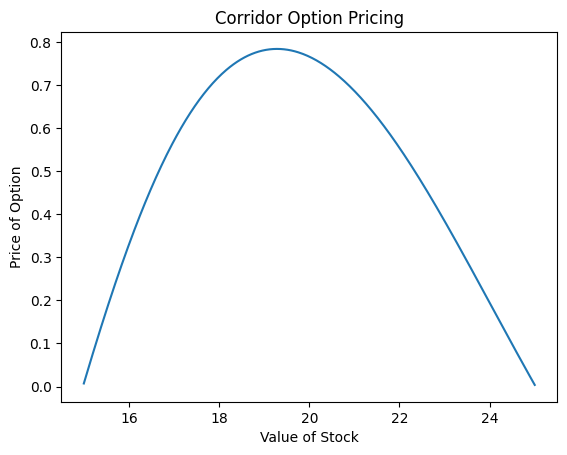

In [20]:
# graph the solution
# 20 = 15 + k 0.02 so k = 5 / 0.02 = 250
print(f'Option Price at t=0, x=20: ${implicit_solution[250, 0]:.4f}')

ax = sns.lineplot(x=np.linspace(15, 25, 501), y=implicit_solution[:, 0])
ax.set_xlabel('Value of Stock')
ax.set_ylabel('Price of Option')
ax.set_title('Corridor Option Pricing')

plt.show()